# Dataset Acquisition and Loading

In [ ]:
#Install dependencies
!pip install -q pyspark kaggle

In [ ]:
# Upload kaggle.json (your Kaggle API token)
from google.colab import files
files.upload()   # Upload your kaggle.json here

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"yomashisanjula","key":"b057cb903c2450bae0ad05edb444a8ae"}'}

In [ ]:
# Move token to correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset (Craigslist Vehicles)
DATASET = "austinreese/craigslist-carstrucks-data"
DOWNLOAD_DIR = "/content/data"

!mkdir -p "{DOWNLOAD_DIR}"
!kaggle datasets download -d "{DATASET}" -p "{DOWNLOAD_DIR}" -q --force
!unzip -o "{DOWNLOAD_DIR}/*.zip" -d "{DOWNLOAD_DIR}"
!rm -f "{DOWNLOAD_DIR}"/*.zip


Dataset URL: https://www.kaggle.com/datasets/austinreese/craigslist-carstrucks-data
License(s): CC0-1.0
Archive:  /content/data/craigslist-carstrucks-data.zip
  inflating: /content/data/vehicles.csv  


In [ ]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("UsedCarPriceAnalysis").getOrCreate()

# Load CSV into Spark DataFrame
df = spark.read.csv("/content/data/vehicles.csv", header=True, inferSchema=True)


#  Understanding the dataset and Preprocessing

In [ ]:
# Number of rows
rows = df.count()

# Number of columns
cols = len(df.columns)

print(f"Dataset shape: ({rows}, {cols})")


Dataset shape: (441802, 26)


In [ ]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: string (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: string (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- posting_date: string (nu

In [ ]:
#Change data types
from pyspark.sql import functions as F
from pyspark.sql import types as T

# 1. Cast numeric columns
numeric_cols = {
    "price": T.FloatType(),
    "year": T.IntegerType(),
    "odometer": T.FloatType(),
    "lat": T.FloatType(),
    "long": T.FloatType()
}

for col, dtype in numeric_cols.items():
    df = df.withColumn(col, F.col(col).cast(dtype))

# 3. Verify schema after conversion
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: float (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: float (nullable = true)
 |-- posting_date: string (nulla

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, NumericType, FloatType, IntegerType

# -----------------------------
# 1. Identify numeric and categorical columns
# -----------------------------
numeric_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, (FloatType, IntegerType))]
cat_cols = [f.name for f in df.schema.fields if isinstance(f.dataType, StringType)]

print(f"Numeric columns: {numeric_cols}")
print(f"Categorical columns: {cat_cols}")

# -----------------------------
# 2. Describe numeric columns
# -----------------------------
if numeric_cols:
    print("\n=== Numeric columns summary ===")
    df.select(numeric_cols).describe().show()

Numeric columns: ['price', 'year', 'odometer', 'lat', 'long']
Categorical columns: ['id', 'url', 'region', 'region_url', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'VIN', 'drive', 'size', 'type', 'paint_color', 'image_url', 'description', 'county', 'state', 'posting_date']

=== Numeric columns summary ===
+-------+--------------------+------------------+------------------+-----------------+----------+
|summary|               price|              year|          odometer|              lat|      long|
+-------+--------------------+------------------+------------------+-----------------+----------+
|  count|              432708|            427248|            422520|           360500|    363110|
|   mean|   74186.53877180508|2005.5689365427106| 98034.05423732448|41.77550319204158|  Infinity|
| stddev|1.2099967635128902E7|112.04572637516512|213873.50163052895|84.63443684342784|       NaN|
|    min|           -158.0309|              -122|        

In [ ]:
df.show(5)

+----------+--------------------+--------------------+--------------------+-------+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|        id|                 url|              region|          region_url|  price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission| VIN|drive|size|type|paint_color|image_url|description|county|state| lat|long|posting_date|
+----------+--------------------+--------------------+--------------------+-------+----+------------+-----+---------+---------+----+--------+------------+------------+----+-----+----+----+-----------+---------+-----------+------+-----+----+----+------------+
|7222695916|https://prescott....|            prescott|https://prescott....| 6000.0|NULL|        NULL| NULL|     NULL|     NULL|NULL|    NULL|        NULL|        NULL|NULL| NULL|NULL|NULL|       NULL|     NULL|       NULL| 

## Data Cleaning

Remove Unnecessary Columns

In [ ]:
# Drop unwanted columns
drop_cols = ["id","url", "region_url", "image_url", "description", "vin", "lat", "long","posting_date","state"]

df = df.drop(*drop_cols)

# Verify remaining columns
print("Remaining columns:", df.columns)


Remaining columns: ['region', 'price', 'year', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'county']


Check missing values

In [ ]:
from pyspark.sql import functions as F

# total rows
total_rows = df.count()

# loop over columns and calculate % of nulls
null_percentages = (
    df.select([
        (F.count(F.when(F.col(c).isNull(), c)) / total_rows * 100).alias(c)
        for c in df.columns
    ])
)

null_percentages.show(truncate=False)


+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+
|region           |price             |year             |manufacturer     |model             |condition         |cylinders        |fuel              |odometer         |title_status     |transmission     |drive            |size            |type             |paint_color      |county           |
+-----------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+------------------+-----------------+-----------------+-----------------+-----------------+----------------+-----------------+-----------------+-----------------+
|1.562011942001168|2.0583881467263616|3.294235879421098|6.549766637543515|3.9624084997351754|42.359020556719976|43.186314

Missing Value Handling

In [ ]:
from pyspark.sql import functions as F

# Drop columns with too many missing values (or selected columns)
drop_cols = ["county", "size"]  # columns you want to drop
df_clean = df.drop(*drop_cols)

# Drop rows that have ANY missing value
df_clean = df_clean.na.drop("any")

# Optional: verify that no missing values remain
from pyspark.sql import functions as F

total_rows = df_clean.count()
missing_percentages = df_clean.select([
    ((F.count(F.when(F.col(c).isNull(), 1)) / total_rows) * 100).alias(c)
    for c in df_clean.columns
])
missing_percentages.show(truncate=False)


+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|region|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|type|paint_color|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|0.0   |0.0  |0.0 |0.0         |0.0  |0.0      |0.0      |0.0 |0.0     |0.0         |0.0         |0.0  |0.0 |0.0        |
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+



In [ ]:
# Number of rows
rows = df_clean.count()

# Number of columns
cols = len(df_clean.columns)

print(f"Dataset shape: ({rows}, {cols})")

Dataset shape: (115988, 14)


Outlier detection

price

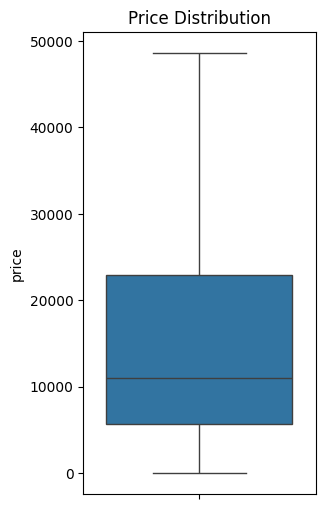

+----------+------------+
|min(price)|  max(price)|
+----------+------------+
|       0.0|3.73692877E9|
+----------+------------+

5th percentile = 2300.0, 95th percentile = 39990.0
+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|            100768|
|   mean|14965.182438869482|
| stddev|10379.012723466383|
|    min|            2300.0|
|    max|           39990.0|
+-------+------------------+



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import functions as F

# ==========================
# Check and visualize 'price'
# ==========================
# Convert df_clean to Pandas for plotting
pdf = df_clean.toPandas()

plt.figure(figsize=(3,6))
sns.boxplot(y='price', data=pdf, showfliers=False)
plt.title("Price Distribution")
plt.show()

# Minimum and Maximum
df_clean.agg(F.min("price"), F.max("price")).show()

# Filter out zero or negative prices
df_clean = df_clean.filter(df_clean.price > 0)

# Filter price outliers using 5th–95th percentile
percentiles_price = df_clean.approxQuantile("price", [0.05, 0.95], 0.0)
lower_price, upper_price = percentiles_price[0], percentiles_price[1]
print(f"5th percentile = {lower_price}, 95th percentile = {upper_price}")

df_clean = df_clean.filter((df_clean.price >= lower_price) & (df_clean.price <= upper_price))
df_clean.describe("price").show()

odometer

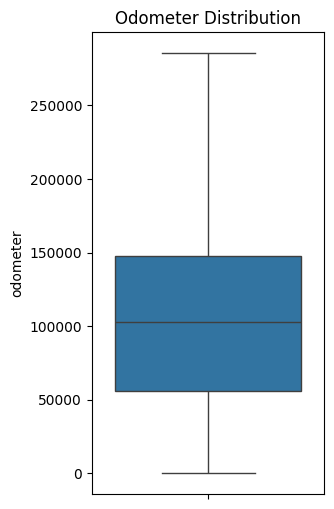

+-------------+-------------+
|min(odometer)|max(odometer)|
+-------------+-------------+
|          0.0|        1.0E7|
+-------------+-------------+

5th percentile = 14647.0, 95th percentile = 215386.0
+-------+-----------------+
|summary|         odometer|
+-------+-----------------+
|  count|            90530|
|   mean|105652.5545012703|
| stddev|50387.81311164716|
|    min|          14647.0|
|    max|         215386.0|
+-------+-----------------+



In [ ]:
# ==========================
# Check and visualize 'odometer'
# ==========================
plt.figure(figsize=(3,6))
sns.boxplot(y='odometer', data=pdf, showfliers=False)
plt.title("Odometer Distribution")
plt.show()

df_clean.agg(F.min("odometer"), F.max("odometer")).show()

# Filter out zero or negative odometer
df_clean = df_clean.filter(df_clean.odometer > 0)

# Filter odometer outliers using 5th–95th percentile
percentiles_odo = df_clean.approxQuantile("odometer", [0.05, 0.95], 0.0)
lower_odo, upper_odo = percentiles_odo[0], percentiles_odo[1]
print(f"5th percentile = {lower_odo}, 95th percentile = {upper_odo}")

df_clean = df_clean.filter((df_clean.odometer >= lower_odo) & (df_clean.odometer <= upper_odo))
df_clean.describe("odometer").show()


year

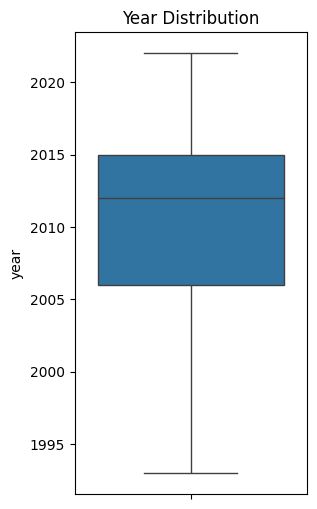

+---------+---------+
|min(year)|max(year)|
+---------+---------+
|     1905|     2022|
+---------+---------+

Lower bound = 1995.0, Upper bound = 2027.0
+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|             86707|
|   mean|2010.9659658389749|
| stddev| 5.165896560086826|
|    min|              1995|
|    max|              2022|
+-------+------------------+



In [ ]:
# ==========================
# Check and visualize 'year'
# ==========================
plt.figure(figsize=(3,6))
sns.boxplot(y='year', data=pdf, showfliers=False)
plt.title("Year Distribution")
plt.show()

df_clean.agg(F.min("year"), F.max("year")).show()

# Filter year outliers using IQR
quantiles_year = df_clean.approxQuantile("year", [0.25, 0.75], 0.0)
Q1, Q3 = quantiles_year[0], quantiles_year[1]
IQR = Q3 - Q1
lower_year = Q1 - 1.5 * IQR
upper_year = Q3 + 1.5 * IQR
print(f"Lower bound = {lower_year}, Upper bound = {upper_year}")

df_clean = df_clean.filter((df_clean.year >= lower_year) & (df_clean.year <= upper_year))
df_clean.describe("year").show()

In [ ]:

# ==========================
# Final dataset info
# ==========================
rows = df_clean.count()
cols = len(df_clean.columns)
print(f"Dataset shape after cleaning: ({rows}, {cols})")

# ==========================
# Check for missing values
# ==========================
total_rows = df_clean.count()

# Count missing values per column
null_counts = df_clean.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df_clean.columns])
print("Number of missing values per column:")
null_counts.show(truncate=False)

# Percentage of missing values per column
null_percent = df_clean.select([
    ((F.count(F.when(F.col(c).isNull(), c)) / total_rows) * 100).alias(c) for c in df_clean.columns
])
print("Percentage of missing values per column:")
null_percent.show(truncate=False)


Dataset shape after cleaning: (86707, 14)
Number of missing values per column:
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|region|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|type|paint_color|
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|0     |0    |0   |0           |0    |0        |0        |0   |0       |0           |0           |0    |0   |0          |
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+

Percentage of missing values per column:
+------+-----+----+------------+-----+---------+---------+----+--------+------------+------------+-----+----+-----------+
|region|price|year|manufacturer|model|condition|cylinders|fuel|odometer|title_status|transmission|drive|type|paint_color|
+------+-----+----+------

# Exploratory Data Analysis

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert Spark DataFrame → Pandas
pdf = df_clean.toPandas()

### PRICE DISTRIBUTION

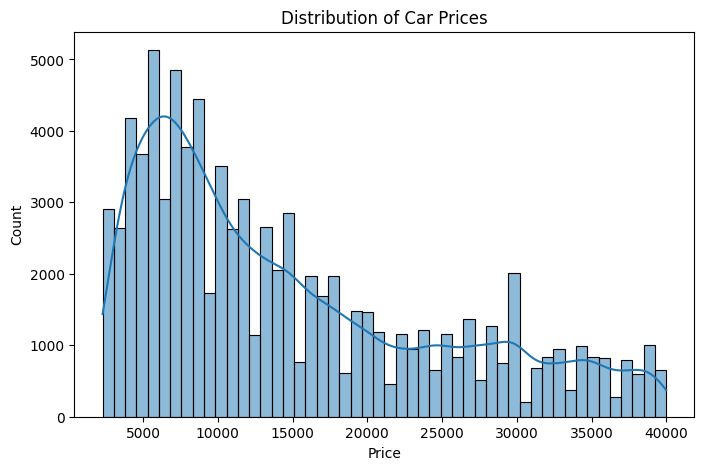

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(pdf["price"], bins=50, kde=True)
plt.title("Distribution of Car Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

### YEAR DISTRIBUTION

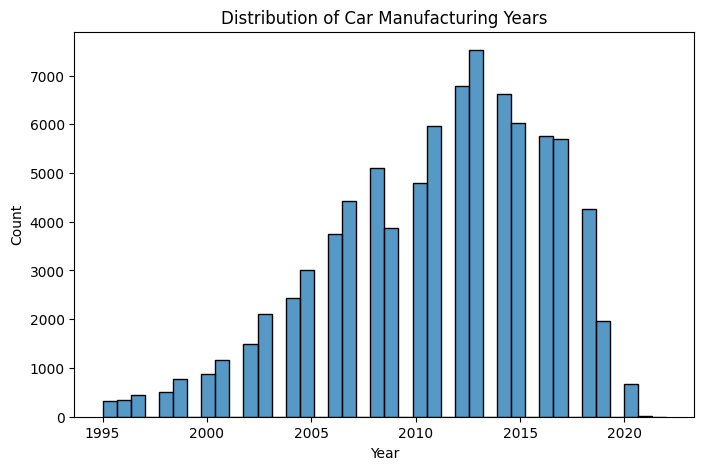

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(pdf["year"].dropna(), bins=40, kde=False)
plt.title("Distribution of Car Manufacturing Years")
plt.xlabel("Year")
plt.ylabel("Count")
plt.show()

### ODOMETER DISTRIBUTION

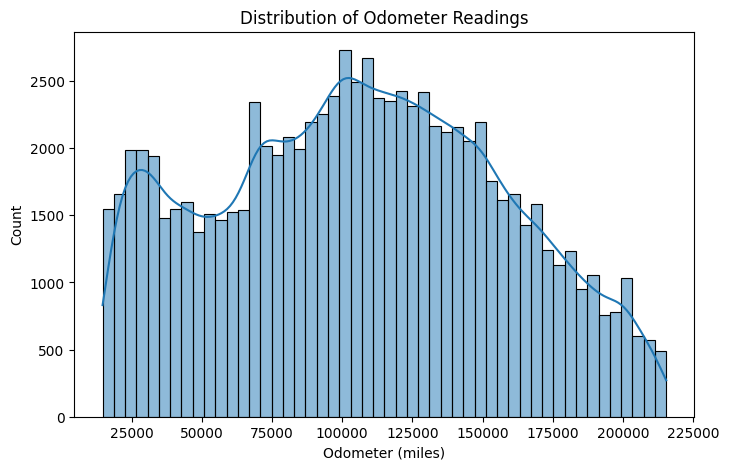

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(pdf["odometer"].dropna(), bins=50, kde=True)
plt.title("Distribution of Odometer Readings")
plt.xlabel("Odometer (miles)")
plt.ylabel("Count")
plt.show()


### PRICE vs YEAR (Scatter)

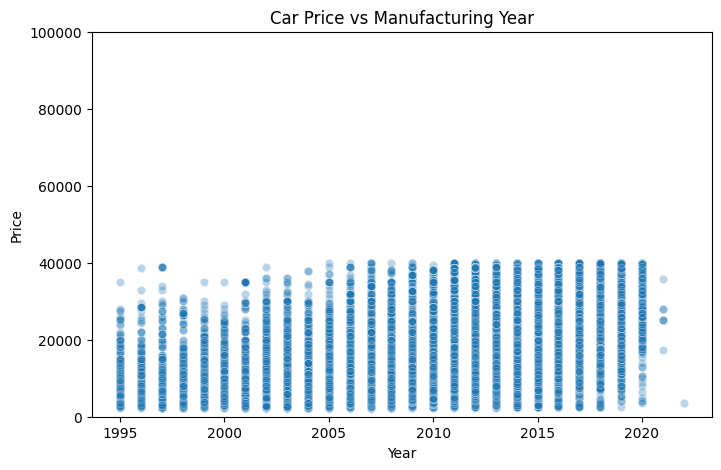

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=pdf, x="year", y="price", alpha=0.3)
plt.title("Car Price vs Manufacturing Year")
plt.xlabel("Year")
plt.ylabel("Price")
plt.ylim(0, 100000)  # limit y-axis to avoid extreme outliers
plt.show()


### PRICE vs ODOMETER (Scatter)

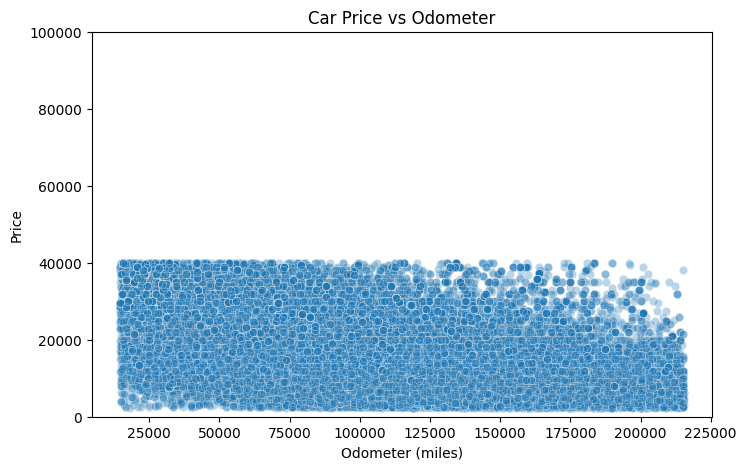

In [ ]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=pdf, x="odometer", y="price", alpha=0.3)
plt.title("Car Price vs Odometer")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price")
plt.ylim(0, 100000)
plt.show()


### AVERAGE PRICE BY MANUFACTURER

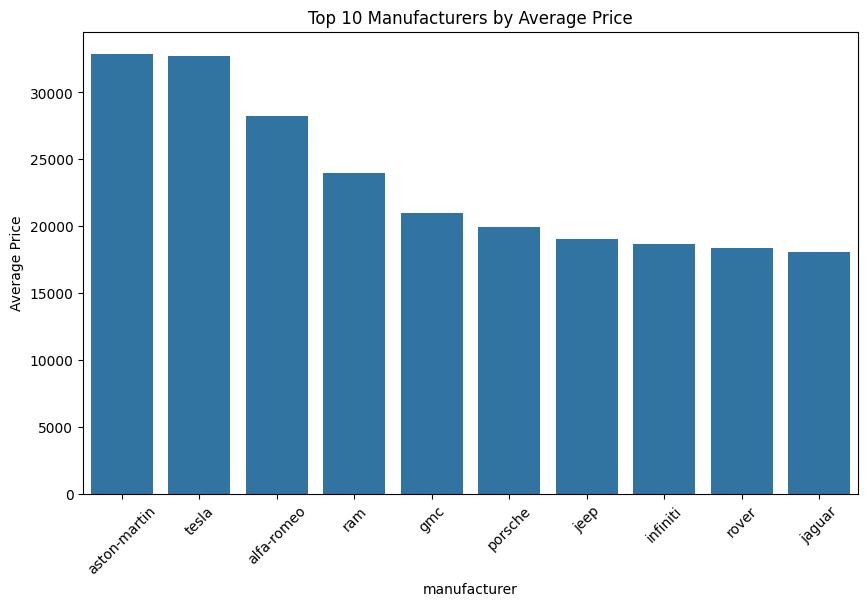

In [ ]:
plt.figure(figsize=(10,6))
avg_price_manufacturer = pdf.groupby("manufacturer")["price"].mean().sort_values(ascending=False)[:10]
sns.barplot(x=avg_price_manufacturer.index, y=avg_price_manufacturer.values)
plt.title("Top 10 Manufacturers by Average Price")
plt.xticks(rotation=45)
plt.ylabel("Average Price")
plt.show()

### COUNT OF LISTINGS BY MANUFACTURER

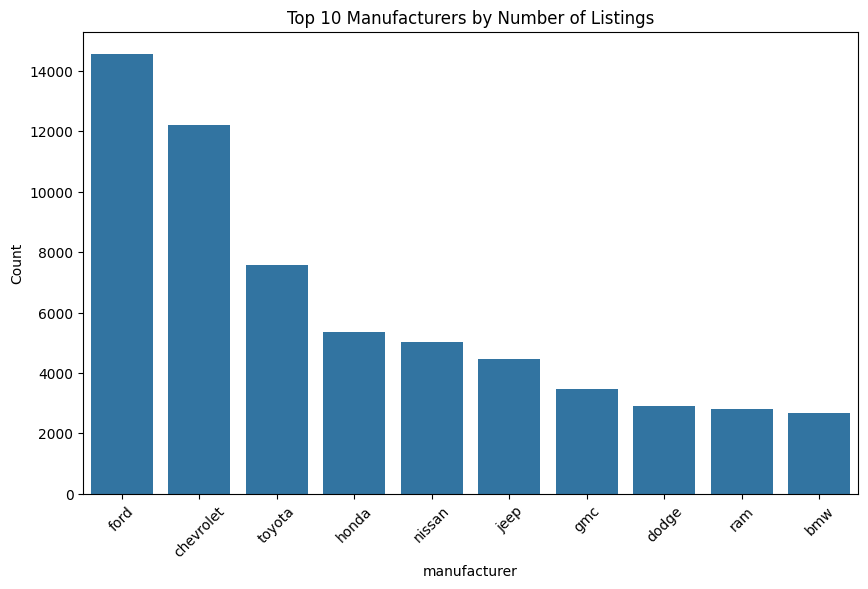

In [ ]:
plt.figure(figsize=(10,6))
top_manufacturers = pdf["manufacturer"].value_counts()[:10]
sns.barplot(x=top_manufacturers.index, y=top_manufacturers.values)
plt.title("Top 10 Manufacturers by Number of Listings")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.show()


### AVERAGE PRICE BY FUEL TYPE

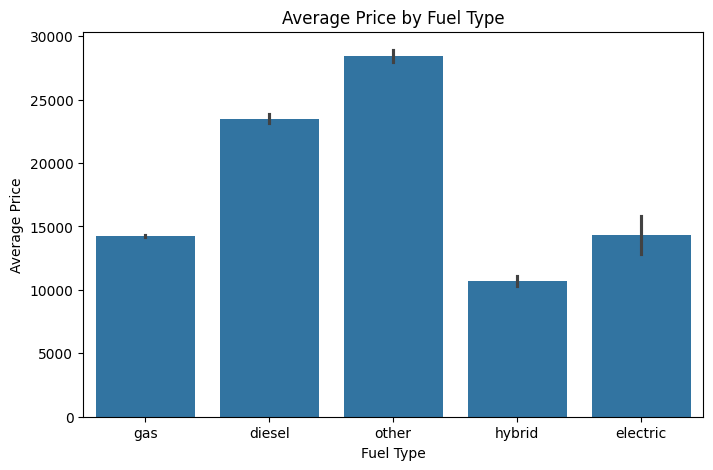

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x="fuel", y="price", data=pdf)
plt.title("Average Price by Fuel Type")
plt.xlabel("Fuel Type")
plt.ylabel("Average Price")
plt.show()

### AVERAGE PRICE BY TRANSMISSION

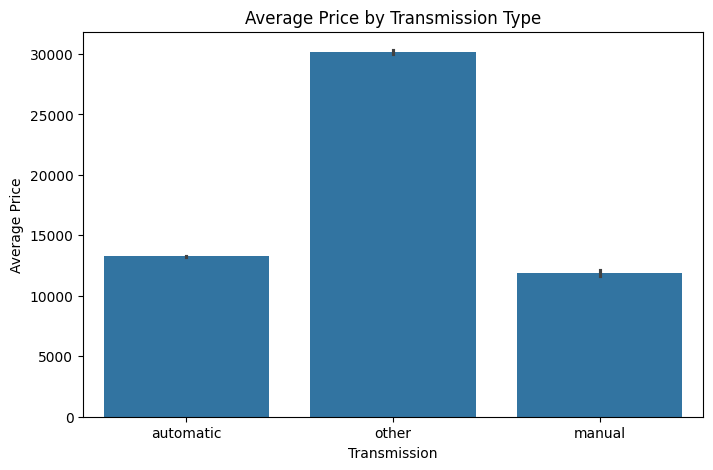

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x="transmission", y="price", data=pdf)
plt.title("Average Price by Transmission Type")
plt.xlabel("Transmission")
plt.ylabel("Average Price")
plt.show()

### AVERAGE PRICE BY DRIVE TYPE

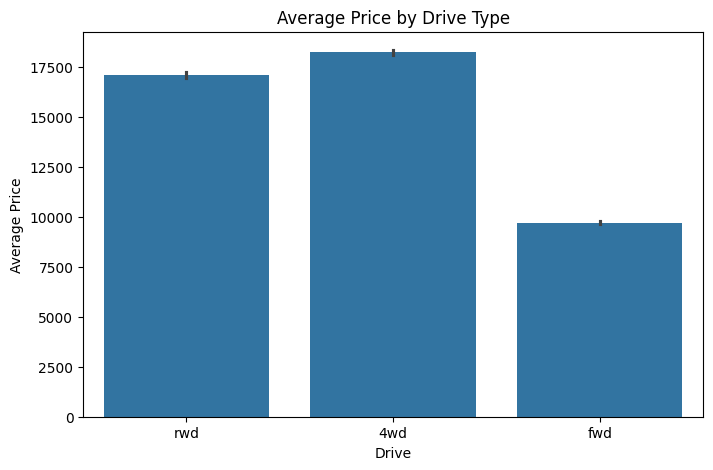

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(x="drive", y="price", data=pdf)
plt.title("Average Price by Drive Type")
plt.xlabel("Drive")
plt.ylabel("Average Price")
plt.show()


### CARS USED BY EACH MANUFACTURER

In [ ]:
import plotly.express as px

# Convert Spark DataFrame → Pandas
pdf = df.toPandas()

# Group by manufacturer and count vehicles
by_manf = pdf.groupby('manufacturer').size().reset_index(name='count').sort_values(by='count', ascending=False)

# Plot
fig = px.bar(
    by_manf.head(10),   # top 10 for clarity
    x='count',
    y='manufacturer',
    title='Cars by Manufacturer',
    labels={'count': 'Number of Cars', 'manufacturer': 'Manufacturer'},
    color='count',
    color_continuous_scale='Reds'
)

fig.update_layout(
    xaxis_title='Number of Cars',
    yaxis_title='Manufacturer',
    yaxis_categoryarray=by_manf['manufacturer'][by_manf['count'].argsort()],
    yaxis_categoryorder='total ascending',
    width=900,
    height=600
)

fig.show()

### MOST COMMON FUEL TYPES

In [ ]:
import plotly.graph_objects as go

# Convert Spark DataFrame → Pandas
pdf = df_clean.toPandas()  # use df_clean after preprocessing

# Group by 'fuel' and calculate counts and ratios
by_fuel = pdf.groupby("fuel").size().reset_index(name="count")
by_fuel["ratio"] = by_fuel["count"] / by_fuel["count"].sum()

# Define colors
colors = ['rgb(128,133,133)', 'rgb(211,94,96)', 'rgb(144,103,167)', 'rgb(171,104,87)', 'rgb(114,147,203)']

# Create pie chart
fig = go.Figure(
    data=[go.Pie(
        labels=by_fuel["fuel"],
        values=by_fuel["ratio"],
        marker=dict(colors=colors, line=dict(color="#FFFFFF", width=2)),
        hole=0.3  # optional: donut chart
    )]
)

fig.update_layout(
    title="Car Fuel Type Distribution",
    width=600,
    height=500
)

fig.show()


### TOP 15 CAR MANUFACTURES

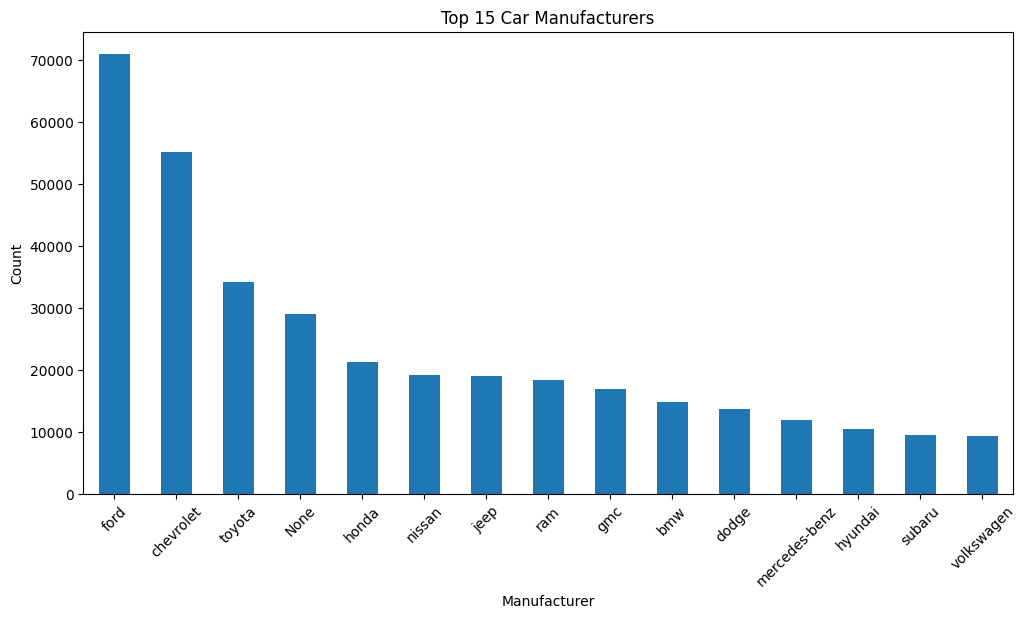

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns


manufacturer_counts = df.groupBy("manufacturer").count().orderBy("count", ascending=False).limit(15)
manufacturer_pd = manufacturer_counts.toPandas()

plt.figure(figsize=(12,6))
manufacturer_pd.set_index("manufacturer")["count"].plot(kind="bar")
plt.title("Top 15 Car Manufacturers")
plt.xlabel("Manufacturer")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


### TOP 10 REGIONS BY AVARAGE PRICE

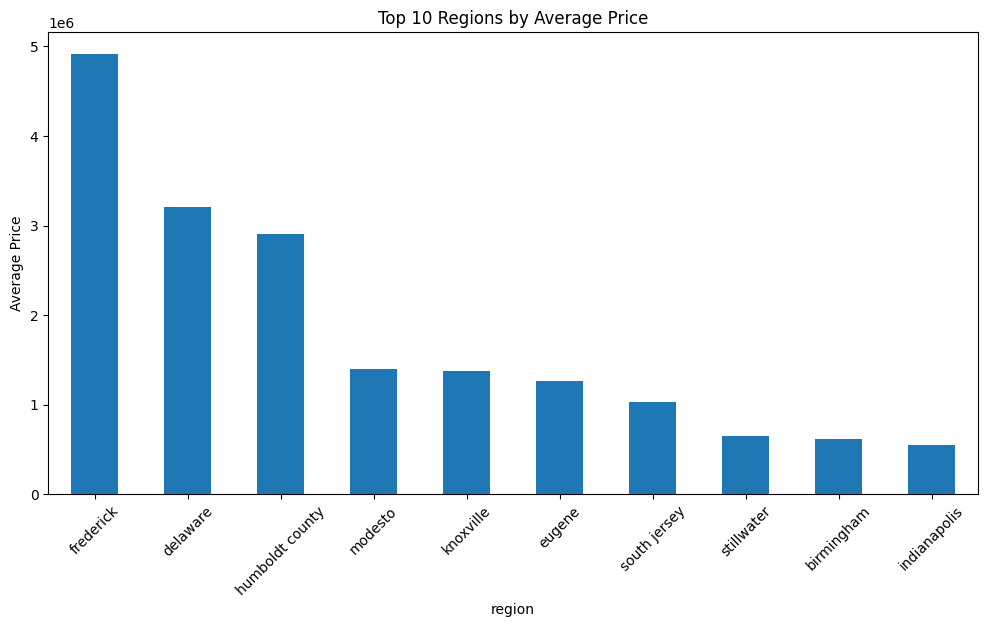

In [ ]:

region_price = df.groupBy("region").avg("price").orderBy("avg(price)", ascending=False).limit(10)
region_price_pd = region_price.toPandas()

plt.figure(figsize=(12,6))
region_price_pd.set_index("region")["avg(price)"].plot(kind="bar")
plt.title("Top 10 Regions by Average Price")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.show()

## CAR CONDITION DISTRIBUTIONS

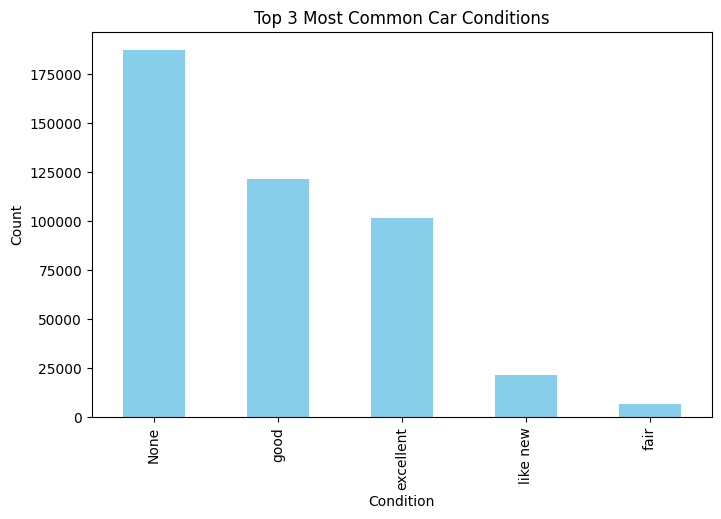

In [ ]:
# Count car conditions and convert to Pandas
condition_counts = df.groupBy("condition").count().orderBy("count", ascending=False)
condition_pd = condition_counts.toPandas()

# Keep only top 3 most common conditions
top_conditions = condition_pd.head(5)

# Plot
plt.figure(figsize=(8,5))
top_conditions.set_index("condition")["count"].plot(kind="bar", color='skyblue')
plt.title("Top 3 Most Common Car Conditions")
plt.xlabel("Condition")
plt.ylabel("Count")
plt.show()


# Data preparation

## Convert categorical into numerical

In [ ]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

# List of categorical columns
categorical_cols = [
    'region','manufacturer','model','condition','cylinders','fuel',
    'title_status','transmission','drive','type','paint_color'
]

# ==========================
# 1️⃣ Label Encoding (Tree-based)
# ==========================
tree_indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid='keep')
    for col in categorical_cols
]

pipeline_tree = Pipeline(stages=tree_indexers)
vehicles_tree = pipeline_tree.fit(df_clean).transform(df_clean)

# Optional: drop original categorical columns and keep indexed ones
for col in categorical_cols:
    vehicles_tree = vehicles_tree.drop(col).withColumnRenamed(col+"_index", col)

# vehicles_tree is now ready for tree-based models
vehicles_tree.show(5)

# ==========================
# 2️⃣ One-Hot Encoding (Regression)
# ==========================
# First, index categorical columns
reg_indexers = [
    StringIndexer(inputCol=col, outputCol=col+"_index", handleInvalid='keep')
    for col in categorical_cols
]

# Then one-hot encode the indexed columns
reg_encoders = [
    OneHotEncoder(inputCol=col+"_index", outputCol=col+"_ohe")
    for col in categorical_cols
]

pipeline_ohe = Pipeline(stages=reg_indexers + reg_encoders)
vehicles_reg = pipeline_ohe.fit(df_clean).transform(df_clean)

# Optional: drop original categorical columns and index columns
for col in categorical_cols:
    vehicles_reg = vehicles_reg.drop(col).drop(col+"_index")

# vehicles_reg now has one-hot encoded vectors for regression models
vehicles_reg.show(5)


+-------+----+--------+------+------------+-----+---------+---------+----+------------+------------+-----+----+-----------+
|  price|year|odometer|region|manufacturer|model|condition|cylinders|fuel|title_status|transmission|drive|type|paint_color|
+-------+----+--------+------+------------+-----+---------+---------+----+------------+------------+-----+----+-----------+
|15000.0|2013|128000.0| 335.0|         0.0|129.0|      0.0|      0.0| 0.0|         0.0|         0.0|  2.0| 2.0|        1.0|
|27990.0|2012| 68696.0| 335.0|         6.0| 94.0|      1.0|      2.0| 0.0|         0.0|         1.0|  0.0| 3.0|        1.0|
|34590.0|2016| 29499.0| 335.0|         1.0| 42.0|      1.0|      0.0| 0.0|         0.0|         1.0|  0.0| 3.0|        2.0|
|35000.0|2019| 43000.0| 335.0|         2.0|  9.0|      0.0|      0.0| 0.0|         0.0|         0.0|  0.0| 2.0|        3.0|
|29990.0|2016| 17302.0| 335.0|         1.0| 45.0|      1.0|      0.0| 0.0|         0.0|         1.0|  0.0| 3.0|        5.0|
+-------

## Feature Scaling

In [ ]:
from pyspark.sql import functions as F

# -----------------------------
# Scale 'odometer' for regression
# -----------------------------
# Compute min and max
min_max_odo = vehicles_reg.agg(
    F.min('odometer').alias('min_odometer'),
    F.max('odometer').alias('max_odometer')
).collect()[0]

min_odo = min_max_odo['min_odometer']
max_odo = min_max_odo['max_odometer']

# Apply min-max scaling with sqrt
vehicles_reg = vehicles_reg.withColumn(
    'odometer_scaled_sqrt',
    F.sqrt((F.col('odometer') - F.lit(min_odo)) / F.lit(max_odo - min_odo))
)

# -----------------------------
# Scale 'year' for regression
# -----------------------------
# Compute min and max
min_max_year = vehicles_reg.agg(
    F.min('year').alias('min_year'),
    F.max('year').alias('max_year')
).collect()[0]

min_year = min_max_year['min_year']
max_year = min_max_year['max_year']

# Apply min-max scaling with sqrt
vehicles_reg = vehicles_reg.withColumn(
    'year_scaled_sqrt',
    F.sqrt((F.col('year') - F.lit(min_year)) / F.lit(max_year - min_year))
)

# Optional: drop original 'odometer' and 'year' columns
vehicles_reg = vehicles_reg.drop('odometer', 'year')

# Verify
vehicles_reg.select('odometer_scaled_sqrt', 'year_scaled_sqrt').show(5)


+--------------------+------------------+
|odometer_scaled_sqrt|  year_scaled_sqrt|
+--------------------+------------------+
|  0.7514509384483151| 0.816496580927726|
|  0.5188931689699052|0.7934920476158722|
| 0.27200481510658026|0.8819171036881969|
| 0.37582323866502343|0.9428090415820634|
| 0.11500491055461962|0.8819171036881969|
+--------------------+------------------+
only showing top 5 rows



# Model Building

## Assemble Features

In [ ]:
from pyspark.ml.feature import VectorAssembler

# Regression features (vehicles_reg)
reg_feature_cols = [c for c in vehicles_reg.columns if c != "price"]

assembler_reg = VectorAssembler(inputCols=reg_feature_cols, outputCol="features")
df_reg_model = assembler_reg.transform(vehicles_reg).select("price", "features")
df_reg_model.show(5)


+-------+--------------------+
|  price|            features|
+-------+--------------------+
|15000.0|(9149,[335,403,57...|
|27990.0|(9149,[335,409,53...|
|34590.0|(9149,[335,404,48...|
|35000.0|(9149,[335,405,45...|
|29990.0|(9149,[335,404,48...|
+-------+--------------------+
only showing top 5 rows



In [ ]:
# Tree-based features (vehicles_tree)
tree_feature_cols = [c for c in vehicles_tree.columns if c != "price"]

assembler_tree = VectorAssembler(inputCols=tree_feature_cols, outputCol="features")
df_tree_model = assembler_tree.transform(vehicles_tree).select("price", "features")
df_tree_model.show(5)


+-------+--------------------+
|  price|            features|
+-------+--------------------+
|15000.0|(13,[0,1,2,4,10,1...|
|27990.0|[2012.0,68696.0,3...|
|34590.0|[2016.0,29499.0,3...|
|35000.0|(13,[0,1,2,3,4,11...|
|29990.0|[2016.0,17302.0,3...|
+-------+--------------------+
only showing top 5 rows



## Train/Test Split

In [ ]:
# Regression
train_reg, test_reg = df_reg_model.randomSplit([0.8, 0.2], seed=42)

# Tree-based
train_tree, test_tree = df_tree_model.randomSplit([0.8, 0.2], seed=42)


## Regression-Based Models

In [ ]:
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# ---- Linear Regression ----
lr = LinearRegression(labelCol="price", featuresCol="features")
lr_model = lr.fit(train_reg)
lr_pred = lr_model.transform(test_reg)

print("Linear Regression Evaluation:")
print("RMSE:", evaluator.evaluate(lr_pred))
print("MAE:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae").evaluate(lr_pred))
print("R2:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(lr_pred))
print("\n")

Linear Regression Evaluation:
RMSE: 3715.349518738231
MAE: 2505.656464445379
R2: 0.8613309159981329




In [ ]:
# ---- Ridge Regression ----
ridge = LinearRegression(labelCol="price", featuresCol="features", regParam=0.1)
ridge_model = ridge.fit(train_reg)
ridge_pred = ridge_model.transform(test_reg)

print("Ridge Regression Evaluation:")
print("RMSE:", evaluator.evaluate(ridge_pred))
print("MAE:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae").evaluate(ridge_pred))
print("R2:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(ridge_pred))
print("\n")


Ridge Regression Evaluation:
RMSE: 3715.104141628552
MAE: 2505.647109697103
R2: 0.8613492319575043




## Tree-Based Models


In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# -----------------------------
# 1️⃣ Decision Tree Regressor
# -----------------------------
# Set maxBins high enough for high-cardinality features
dt = DecisionTreeRegressor(labelCol="price", featuresCol="features", maxBins=9000)
dt_model = dt.fit(train_tree)
dt_pred = dt_model.transform(test_tree)

print("Decision Tree Evaluation:")
print("RMSE:", evaluator.evaluate(dt_pred))
print("MAE:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae").evaluate(dt_pred))
print("R2:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(dt_pred))
print("\n")

Decision Tree Evaluation:
RMSE: 7157.87417320702
MAE: 4058.824275922463
R2: 0.48530681911342133




In [ ]:
# -----------------------------
# 2️⃣ Random Forest Regressor
# -----------------------------
# Random Forest can handle high-cardinality features if maxBins is large
rf = RandomForestRegressor(labelCol="price", featuresCol="features", numTrees=50, maxBins=9000)
rf_model = rf.fit(train_tree)
rf_pred = rf_model.transform(test_tree)

print("Random Forest Evaluation:")
print("RMSE:", evaluator.evaluate(rf_pred))
print("MAE:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae").evaluate(rf_pred))
print("R2:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(rf_pred))


Random Forest Evaluation:
RMSE: 5074.827132786367
MAE: 3425.2032354787825
R2: 0.7412842899810193


In [ ]:
from pyspark.sql import Row
from pyspark.sql import SparkSession

# Function to get metrics
def get_metrics(pred_df, label="price"):
    rmse = evaluator.evaluate(pred_df)
    mae = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="mae").evaluate(pred_df)
    r2 = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="r2").evaluate(pred_df)
    return rmse, mae, r2

# Collect metrics
metrics = [
    Row(model="Linear Regression", rmse=get_metrics(lr_pred)[0], mae=get_metrics(lr_pred)[1], r2=get_metrics(lr_pred)[2]),
    Row(model="Ridge Regression", rmse=get_metrics(ridge_pred)[0], mae=get_metrics(ridge_pred)[1], r2=get_metrics(ridge_pred)[2]),
    Row(model="Decision Tree", rmse=get_metrics(dt_pred)[0], mae=get_metrics(dt_pred)[1], r2=get_metrics(dt_pred)[2]),
    Row(model="Random Forest", rmse=get_metrics(rf_pred)[0], mae=get_metrics(rf_pred)[1], r2=get_metrics(rf_pred)[2])
]

# Create Spark DataFrame
metrics_df = spark.createDataFrame(metrics)

# Show comparison
metrics_df.show(truncate=False)


+-----------------+-----------------+------------------+-------------------+
|model            |rmse             |mae               |r2                 |
+-----------------+-----------------+------------------+-------------------+
|Linear Regression|3715.349518738231|2505.656464445379 |0.8613309159981329 |
|Ridge Regression |3715.104141628552|2505.647109697103 |0.8613492319575043 |
|Decision Tree    |7157.87417320702 |4058.824275922463 |0.48530681911342133|
|Random Forest    |5074.827132786367|3425.2032354787825|0.7412842899810193 |
+-----------------+-----------------+------------------+-------------------+



# HyperparameterTunning

In [ ]:
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# 1️⃣ Define Ridge Regression (actually LinearRegression with regParam)
ridge = LinearRegression(labelCol="price", featuresCol="features")

# 2️⃣ Define evaluator
evaluator = RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="rmse")

# 3️⃣ Create parameter grid for tuning
paramGrid = (ParamGridBuilder()
             .addGrid(ridge.regParam, [0.01, 0.1, 1.0, 10.0])   # Ridge strength
             .addGrid(ridge.elasticNetParam, [0.0])             # 0.0 = pure Ridge
             .build())

# 4️⃣ Cross-validator setup
crossval = CrossValidator(estimator=ridge,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)   # 5-fold CV

# 5️⃣ Fit model
cvModel = crossval.fit(train_reg)

# 6️⃣ Best model from CV
bestModel = cvModel.bestModel

# 7️⃣ Evaluate on test data
ridge_pred = bestModel.transform(test_reg)

print("Best Ridge Regression Results:")
print("Best regParam:", bestModel._java_obj.getRegParam())
print("Best elasticNetParam:", bestModel._java_obj.getElasticNetParam())
print("RMSE:", evaluator.evaluate(ridge_pred))
print("MAE:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="mae").evaluate(ridge_pred))
print("R2:", RegressionEvaluator(labelCol="price", predictionCol="prediction", metricName="r2").evaluate(ridge_pred))


Best Ridge Regression Results:
Best regParam: 10.0
Best elasticNetParam: 0.0
RMSE: 3703.574519572725
MAE: 2499.1754404822727
R2: 0.8622084866770142


# Feature Importance

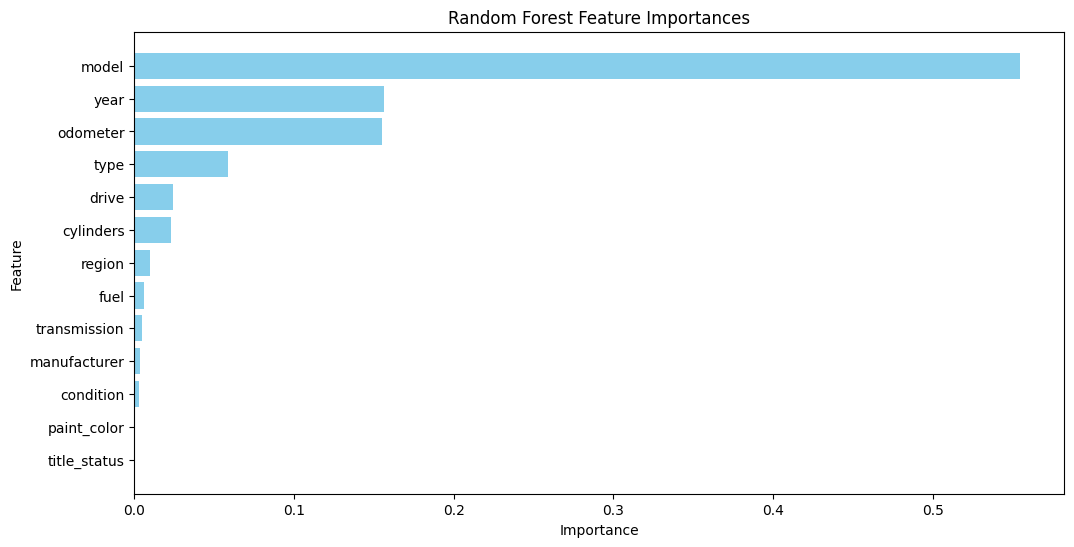

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Extract Feature Importances
# -----------------------------
# rf_model.featureImportances returns a SparseVector
importances = rf_model.featureImportances

# Use the same feature columns from assembler_tree
feature_names = assembler_tree.getInputCols()

# Pair feature names with importance values
feat_imp = list(zip(feature_names, importances.toArray()))

# Convert to DataFrame for easy plotting
feat_imp_df = pd.DataFrame(feat_imp, columns=["Feature", "Importance"])
feat_imp_df = feat_imp_df.sort_values(by="Importance", ascending=False)

# -----------------------------
# Plot Feature Importances
# -----------------------------
plt.figure(figsize=(12, 6))
plt.barh(feat_imp_df["Feature"], feat_imp_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()  # Highest importance on top
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importances")
plt.show()


# Residual Distribution

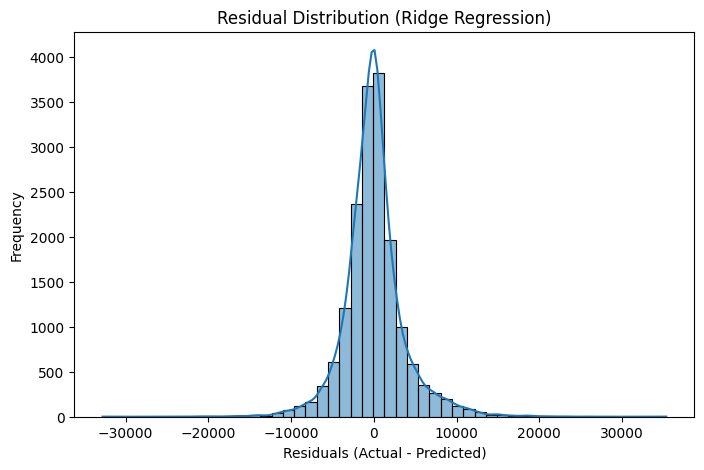

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert predictions to Pandas for plotting
ridge_pred_pd = ridge_pred.select("price", "prediction").toPandas()

# 1️⃣ Residual Analysis (Error Distribution)
ridge_pred_pd["residuals"] = ridge_pred_pd["price"] - ridge_pred_pd["prediction"]

plt.figure(figsize=(8,5))
sns.histplot(ridge_pred_pd["residuals"], bins=50, kde=True)
plt.title("Residual Distribution (Ridge Regression)")
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()



# Predicted vs Actucal plot

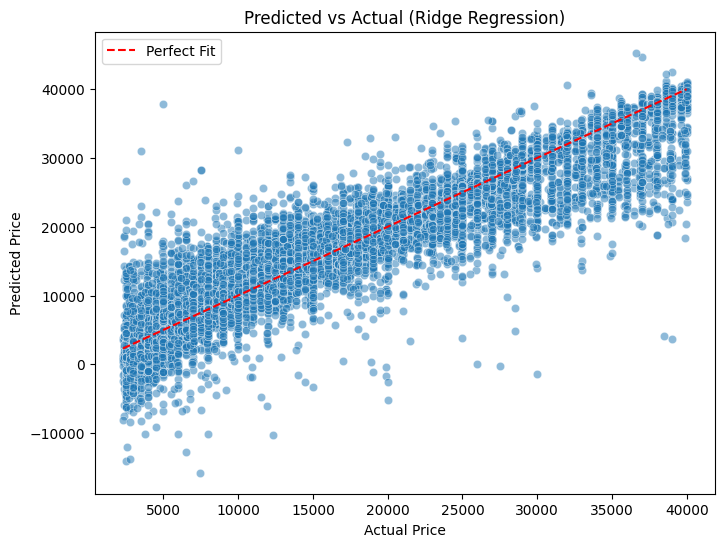

In [ ]:
# 2️⃣ Predicted vs Actual Plot
plt.figure(figsize=(8,6))
sns.scatterplot(x="price", y="prediction", data=ridge_pred_pd, alpha=0.5)
plt.plot([ridge_pred_pd["price"].min(), ridge_pred_pd["price"].max()],
         [ridge_pred_pd["price"].min(), ridge_pred_pd["price"].max()],
         color="red", linestyle="--", label="Perfect Fit")
plt.title("Predicted vs Actual (Ridge Regression)")
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()
